# Hi there

I'm trying to filter 2xdaily OLR data for the Eastward, 2-25 day component

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import cartopy.crs as ccrs
import pandas as pd

In [18]:
"""
A random year of 2xdaily tropical OLR observations
(This is test data from Brian Medeiros, I don't know exactly what dates it is from)
"""
olr = xr.open_dataset("OLR.tropics.12hr_1yrs.wheeler.nc", decode_times=False)['olr']
olr['time'] = pd.date_range('1979-01-01-00', '1979-12-31-12', freq='12H')
olr

<xarray.DataArray 'olr' (time: 730, lat: 17, lon: 144)>
[1787040 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-12-31T12:00:00
  * lat      (lat) float32 -20.0 -17.5 -15.0 -12.5 -10.0 ... 12.5 15.0 17.5 20.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:      W/m2
    long_name:  OLR

## filtering code

Taken mostly from Spencer Clark [https://gist.github.com/spencerkclark/80e915e2afd903cb54ef1a5923be8fe2]

In [10]:
import dask.array as darray

def _fft(arr, *args, **kwargs):
    if isinstance(arr, darray.Array):
        return darray.fft.fft(arr, *args, **kwargs)
    else:
        return np.fft.fft(arr, *args, **kwargs)


def fft(da, dim, n=None, d=1.0, transformed_dim_name="freq", invert_freq=False):
    """Compute the one-dimensional discrete Fourier Transform

    Proceeds as follows:
    1. Compute the transform
    2. Rename the dimension it was applied along
    3. Compute the frequencies
    4. Shift the frequencies and data such the the zero frequency is in the
    center

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray, can be complex
    dim : str
        Dimension name upon which to compute the transform
    n : int, optional (default None)
        Length of the transformed axis of the output.  If `n` is smaller than
        the length of the input, the input is cropped.  If it is larger, the
        input is padded with zeros.  If `n` is not given, the length of the
        input along the axis specified by the dimension used.
    d : scalar
        Sample spacing (inverse of the sampling rate).  Defaults to 1.0.
    transformed_dim_name : str
        Dimension name after transform.
    invert_freq : bool
        Whether to scale the inferred frequency by minus one (e.g. if by
        convention we write the frequency as -omega).

    Returns
    -------
    xr.DataArray
        The truncated or zero-padded input, transformed along the given
        dimension, with coordinates computed by `np.fftfreq`.  Frequencies are
        shifted such that the zero frequency occurs in the middle.
    """
    result = xr.apply_ufunc(
        _fft,
        da,
        input_core_dims=[(dim,)],
        output_core_dims=[(dim,)],
        kwargs={"n": n},
        dask="allowed",
    )
    result = result.rename({dim: transformed_dim_name})
    size = result.sizes[transformed_dim_name]
    result[transformed_dim_name] = np.fft.fftfreq(size, d)
    result[transformed_dim_name] = fftshift(
        result[transformed_dim_name], transformed_dim_name
    )
    if invert_freq:
        result[transformed_dim_name] = -result[transformed_dim_name]
    return fftshift(result, transformed_dim_name)


def _fftshift(arr, *args, **kwargs):
    if isinstance(arr, darray.Array):
        return darray.fft.fftshift(arr, *args, **kwargs)
    else:
        return np.fft.fftshift(arr, *args, **kwargs)


def fftshift(da, dim):
    """Shift the zero-frequency component to the center of the spectrum

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray
    dim : str
        Dimension over which to apply the shift

    Returns
    -------
    xr.DataArray
    """
    return xr.apply_ufunc(
        _fftshift,
        da,
        input_core_dims=[(dim,)],
        output_core_dims=[(dim,)],
        kwargs={"axes": -1},
        dask="allowed",
    )


def _ifftshift(arr, *args, **kwargs):
    if isinstance(arr, darray.Array):
        return darray.fft.ifftshift(arr, *args, **kwargs)
    else:
        return np.fft.ifftshift(arr, *args, **kwargs)


def ifftshift(da, dim):
    """Inverse fftshift

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray
    dim : str
        Dimension over which to apply the inverse shift

    Returns
    -------
    xr.DataArray
    """
    return xr.apply_ufunc(
        _ifftshift,
        da,
        input_core_dims=[(dim,)],
        output_core_dims=[(dim,)],
        kwargs={"axes": -1},
        dask="allowed",
    )


def _ifft(arr, *args, **kwargs):
    if isinstance(arr, darray.Array):
        return darray.fft.ifft(arr, *args, **kwargs)
    else:
        return np.fft.ifft(arr, *args, **kwargs)


def ifft(da, dim, n=None, norm=None):
    """Compute the one-dimensional inverse discrete Fourier Transform.

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray
    dim : str
        Dimension name
    n : int, optional
        Length of the transformed axis of the output

    Returns
    -------
    xr.DataArray
    """
    return xr.apply_ufunc(
        _ifft,
        da,
        input_core_dims=[(dim,)],
        output_core_dims=[(dim,)],
        kwargs={"n": n, "axis": -1},
        dask="allowed",
    )


def sample_spacing(da, dim, scale=360.0):
    """Compute the sample spacing along a given dimension for use
    in fftfreq.

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray
    dim : str
        Name of dimension
    scale : float
        Scale factor to divide by (e.g. 360.0 for longitude)

    Returns
    -------
    float
    """
    result = (da[dim].isel(**{dim: 1}) - da[dim].isel(**{dim: 0})) / scale
    return result.item()
    
    
def spectrally_filter(
    da, dim, n=None, d=1.0, invert_freq=False, bounds=(-np.inf, np.inf)
):
    """Filter DataArray along a given dimension by masking out certain
    modes.

    Parameters
    ----------
    da : xr.DataArray
        Input DataArray, can be complex
    dim : str
        Dimension name upon which to compute the transform
    n : int, optional (default None)
        Length of the transformed axis of the output.  If `n` is smaller than
        the length of the input, the input is cropped.  If it is larger, the
        input is padded with zeros.  If `n` is not given, the length of the
        input along the axis specified by the dimension used.
    d : scalar
        Sample spacing (inverse of the sampling rate).  Defaults to 1.0.
    invert_freq : bool
        Invert the transformed dimension
    bounds : tuple
        Range of wavenumbers or frequencies to keep

    Returns
    -------
    xr.DataArray
    """
    lower_bound, upper_bound = bounds
    transformed = fft(da, dim, n=n, d=d, invert_freq=invert_freq)
    condition = (transformed.freq >= lower_bound) & (transformed.freq <= upper_bound)
    filtered = transformed.where(condition).fillna(0.0)
    inverted = ifft(ifftshift(filtered, "freq").chunk({"freq": -1}), "freq").rename(
        {"freq": dim}
    )
    inverted[dim] = da[dim]
    return inverted

In [11]:
def kelvin_filter_wallace(p, londim='lon'):
    """
    Eastward, 2-25day filtered OLR
    """
    p = p.chunk({"time": -1, londim: -1})
    dt = sample_spacing(p, "time", np.timedelta64(1, "D"))
    dx = sample_spacing(p, londim, 360.0)
    
    # Filter in frequency space
    time_filtered = spectrally_filter(
        p, "time", invert_freq=True, d=dt, bounds=(0.04, 0.5)
    )

    # Filter in wavenumber space
    space_filtered = spectrally_filter(time_filtered, londim, d=dx, bounds=(1, 20))
    return space_filtered.real

In [22]:
kelvin_filtered_olr = kelvin_filter_wallace(olr)

Text(0.5, 1.0, 'Variance of Kelvin OLR / (W m$^{-2}$)$^{2}$')

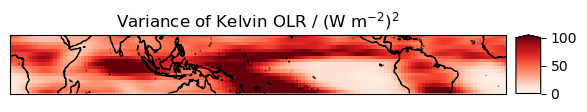

In [25]:
# OBS
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
p=(kelvin_filtered_olr.std('time')**2).plot(ax=ax, vmin=0, vmax=100, cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()
cb=fig.colorbar(p, cax=ax.inset_axes([1.02, 0, 0.05, 1]), extend='max') 
ax.set_title(r"Variance of Kelvin OLR / (W m$^{-2}$)$^{2}$")